In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

## Data Preparing

In [3]:
data_dir = '/content/drive/MyDrive/train'

pthlib = pathlib.Path(data_dir)
image_count = len(list(pthlib.glob('*/*.jpg')))
print(image_count)

4038


In [4]:
datagen = ImageDataGenerator(
  rescale = 1/255,
  rotation_range=30,
  brightness_range=[0.5,1.5],
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  width_shift_range=0.2,
  height_shift_range=0.2,
  validation_split=0.2  
)

In [5]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 3241 images belonging to 25 classes.
Found 798 images belonging to 25 classes.


## Model Building

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (128, 128, 3), include_top = False, weights = "imagenet")
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(512, activation='relu'),
                                 tf.keras.layers.Dense(25, activation="softmax")                                     
                                ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dropout (Dropout)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 512)               10486272  
                                                                 
 dense_1 (Dense)             (None, 25)                12825     
                                                                 
Total params: 12,757,081
Trainable params: 10,499,097
Non-trainable params: 2,257,984
____________________________________

In [8]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

result = model.fit(train_generator, steps_per_epoch=train_generator.samples//32, epochs = 20, verbose=1, validation_data=val_generator, validation_steps=val_generator.samples//32)

Epoch 1/20
101/101 [==============================] - 932s 9s/step - loss: 1.9437 - accuracy: 0.6261 - val_loss: 1.1073 - val_accuracy: 0.6901
Epoch 2/20
101/101 [==============================] - 130s 1s/step - loss: 0.7190 - accuracy: 0.7850 - val_loss: 0.9341 - val_accuracy: 0.7318
Epoch 3/20
101/101 [==============================] - 117s 1s/step - loss: 0.6360 - accuracy: 0.8087 - val_loss: 1.1288 - val_accuracy: 0.7214
Epoch 4/20
101/101 [==============================] - 110s 1s/step - loss: 0.5849 - accuracy: 0.8258 - val_loss: 1.0323 - val_accuracy: 0.7253
Epoch 5/20
101/101 [==============================] - 112s 1s/step - loss: 0.4497 - accuracy: 0.8585 - val_loss: 0.9812 - val_accuracy: 0.7474
Epoch 6/20
101/101 [==============================] - 130s 1s/step - loss: 0.4647 - accuracy: 0.8607 - val_loss: 0.9665 - val_accuracy: 0.7461
Epoch 7/20
101/101 [==============================] - 110s 1s/step - loss: 0.4123 - accuracy: 0.8744 - val_loss: 1.0259 - val_accuracy: 0.7396

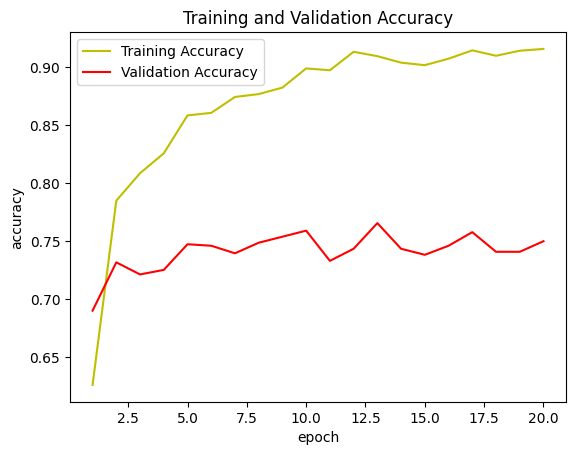

In [9]:
loss = result.history['accuracy']
val_loss = result.history['val_accuracy']
epochs = range(1,len(loss)+1)

import matplotlib.pyplot as plt
plt.plot(epochs,loss,'y',label='Training Accuracy')
plt.plot(epochs,val_loss,'r',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Model Evaluation

In [10]:
x=np.concatenate([val_generator.next()[0] for i in range(val_generator.__len__())])
y=np.concatenate([val_generator.next()[1] for i in range(val_generator.__len__())])
print(x.shape)
print(y.shape)

(798, 128, 128, 3)
(798, 25)


In [11]:
predict_x=model.predict(x,batch_size=32) 
classes_x=np.argmax(predict_x,axis=1)
y=np.argmax(y,axis=1)

25/25 [==============================] - 13s 493ms/step


In [12]:
print(classification_report(y,classes_x))

              precision    recall  f1-score   support

           0       0.39      0.30      0.34        50
           1       0.86      0.50      0.63        12
           2       0.86      0.88      0.87        34
           3       1.00      0.47      0.64        30
           4       1.00      0.94      0.97        18
           5       0.50      0.08      0.14        12
           6       0.85      0.79      0.82        29
           7       0.76      0.79      0.78        33
           8       0.75      1.00      0.86        12
           9       0.96      0.98      0.97        81
          10       0.90      0.60      0.72        43
          11       0.99      0.94      0.96        79
          12       0.29      0.11      0.16        18
          13       0.95      0.91      0.93        67
          14       0.45      0.75      0.57        20
          15       0.64      0.95      0.76        22
          16       0.59      0.84      0.69        49
          17       0.42    